In [132]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.misc.productivity import faculty_at_institution
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from scipy.special import gamma as gammaf
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.cross_validation import StratifiedKFold, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from collections import Counter
from scipy import interp
import statsmodels.api as sm
import numpy as np
import math
import scipy as sp
import pandas as pd
import os
import mpld3
import palettable

sig_level = 0.05

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Code/src/github.com/allisonmorgan/faculty_hiring/notebooks-productivity/figures/'
#nces_table = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/nces_table.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [48]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst)
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']

load.load_all_publications(asst_faculty, dblp_dir)

In [49]:
valid_titles = ['Assistant Professor', 'Associate Professor', 'Full Professor']

In [50]:
followup_data = '/Users/allisonmorgan/Code/src/github.com/allisonmorgan/faculty_hiring/notebooks-productivity/Finalized_Spreadsheet_Nov21.tsv'

def load_followup_data(faculty, followup_file):
    """ Loads the follow-up spreadsheet data collected by BuffTurkers in Nov2016 """
    df = pd.read_csv(followup_file, sep='\t')
    profiles_updated = 0
    
    for person in faculty:
        # When collection assignements are created, these fields are written out:
        # person.facultyName, person.place, person.current
        num_records = len(df[df['Faculty name'] == person.facultyName])
        if num_records == 0: # No matches, this is fine
            continue  
        elif num_records == 1: # One match, this is great
            row = df[df['Faculty name'] == person.facultyName]
            if row['Institution (2011)'].iloc[0] != person.place:
                continue
            person['followup_title'] = row['Job Title (2016)'].iloc[0]
            person['followup_location'] = row['Institution (2016)'].iloc[0]
            person['followup_department'] = row['Department (2016)'].iloc[0]
            profiles_updated += 1
        else: # Multiple matches, this... is bad. Blow up.
            raise ValueError('Multiple records detected!')
            
    assert (profiles_updated <= len(df))
    print 'Updated %d profiles!' % (profiles_updated)

load_followup_data(asst_faculty, followup_data)

Updated 555 profiles!


## Compare with Publications

In [51]:
trajectories = Counter()
for person in asst_faculty:
    if 'followup_title' in person and 'current' in person:
        key = "%s -> %s" % (person['current'], person['followup_title'])
        trajectories[key] += 1
trajectories

Counter({'Assistant Professor -> Assistant Professor': 104,
         'Assistant Professor -> Associate Professor': 366,
         'Assistant Professor -> Full Professor': 17,
         'Assistant Professor -> NOT TT': 68})

In [52]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
# Set limit_by_years_post_hire flag to True to consider only the contributions within the first 5 
# years of a researcher's career.
limit_by_years_post_hire = True
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']
pubs_by_inst = {}
pubs_by_year_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []; n_pubs_by_year = [];
    for person in current_faculty:
        start = person.first_asst_job_year
        if limit_by_years_post_hire:
            end = np.min([2012, person.first_asst_job_year + 5])
        else:
            end = 2012
        career_length = end - start
        
        if person.__contains__('dblp_pubs'):
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub \
                      and pub['year'] >= start \
                      and pub['year'] < end \
                      and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            
            n_pubs.append((person.facultyName, contribution))
            n_pubs_by_year.append((person.facultyName, contribution/float(career_length)))
    if len(n_pubs) > 0:
        pubs_by_inst[name] = n_pubs
        pubs_by_year_by_inst[name] = n_pubs_by_year

In [113]:
# Compare the average publication rate of a person in their first five years, 
# to the average publication rate of faculty within their first five years at
# both the institution they came from and went to
publication_trajectories = []
for person in asst_faculty:
    if 'followup_title' in person and person.__contains__('dblp_pubs'):
        initial_institution = person.current_job()[0]
        final_institution = person['followup_location']
        
        # Get average publication rate of the young faculty at either institution
        # This will skip anyone who left academia
        if pubs_by_year_by_inst.has_key(initial_institution) and pubs_by_year_by_inst.has_key(final_institution):
            initial_counts = [count for (_, count) in pubs_by_year_by_inst[initial_institution]]
            initial_scatter, initial_pub_rate, initial_pub_std = sp.stats.lognorm.fit(initial_counts)
            
            final_counts = [count for (_, count) in pubs_by_year_by_inst[final_institution]]
            final_scatter, final_pub_rate, final_pub_std = sp.stats.lognorm.fit(final_counts)
            
            # Get this faculty member's publication rate
            start = person.current_job()[1]
            end = np.min([2012, start + 5])
            career_length = end - start
        
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub \
                      and pub['year'] >= start \
                      and pub['year'] < end \
                      and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            personal_pub_rate = (contribution/float(career_length))
            
            publication_trajectories.append((personal_pub_rate, (initial_scatter, initial_pub_rate, initial_pub_std), (final_scatter, final_pub_rate, final_pub_std)))

In [139]:
# How many times was the final institution a better fit?
final = 0; num_people = 0; 
for (personal, (initial_scatter, initial_mu, initial_sigma), (final_scatter, final_mu, final_sigma)) in publication_trajectories:
    likelihood_of_final = sp.stats.lognorm.pdf(personal, initial_scatter, loc=initial_mu, scale=final_sigma)
    likelihood_of_initial = sp.stats.lognorm.pdf(personal, final_scatter, loc=final_mu, scale=initial_sigma)
    
    #print(likelihood_of_final, likelihood_of_initial)
    if likelihood_of_final >= likelihood_of_initial:
        final += 1
    num_people += 1

In [140]:
final/num_people

0.9208333333333333

## Basic statistics

In [7]:
num_female = 0.
num_male = 0.
for person in asst_faculty:
    if 'followup_title' in person:
        if person.is_female:
            num_female += 1
        else:
            num_male += 1

overall_gender_ratio = num_female / (num_female + num_male)
print overall_gender_ratio
print num_female, num_male

0.218018018018
121.0 434.0


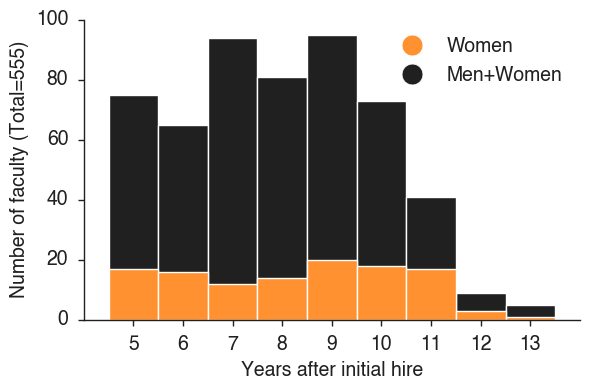

In [5]:
# How far along are these individuals?
years = []
years_men = []
years_women = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.is_female:
            add_to = years_women
        else:
            add_to = years_men
        start_year = person.first_asst_job_year
        career_length = 2016 - start_year
        
        add_to.append(career_length)
        years.append(career_length)

fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)
        
bins = np.arange(15) - 0.5
ax.hist(years, bins=bins, edgecolor='w', color=ALMOST_BLACK)
ax.hist(years_women, bins=bins, edgecolor='w', color=ACCENT_COLOR_1)
ax.set_xlim(4, 14)
ax.set_xticks(np.arange(5,14))
ax.set_xlabel('Years after initial hire')
ax.set_ylabel('Number of faculty (Total=%d)' % (len(years)))

fake_line_1 = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line_2 = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
leg = ax.legend((fake_line_2,fake_line_1),('Women','Men+Women'), numpoints=1, loc='upper right', 
                  frameon=False, fontsize=LABEL_SIZE)

finalize(ax)
plt.show()

In [8]:
# How many people are still tenture track at one of our in-sample universities?
count = 0
possible = 0
men = 0
women = 0

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location in inst and person.followup_title != 'NOT TT':
            count += 1
            if person.is_female:
                women += 1
            else:
                men += 1
        possible += 1

print '%d/%d (%.1f%%) are still around' % (count, possible, (100.*count)/possible)
print '%d/%d (%.1f%%) of those are women' % (women, men+women, (100. * women) / (men + women))

print sp.stats.binom_test(women, men+women, overall_gender_ratio)

474/555 (85.4%) are still around
107/474 (22.6%) of those are women
0.696976805452


In [10]:
# How many people left?
count = 0
possible = 0
men = 0
women = 0

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location not in inst or person.followup_title == 'NOT TT':
            count += 1
            if person.is_female:
                women += 1
            else:
                men += 1
        possible += 1

print '%d/%d (%.1f%%) have left' % (count, possible, (100.*count)/possible)
print '%d/%d (%.1f%%) of those are women' % (women, men+women, (100. * women) / (men + women))

print sp.stats.binom_test(women, men+women, overall_gender_ratio, alternative='less')

81/555 (14.6%) have left
14/81 (17.3%) of those are women
0.199560785183


In [11]:
# How many people left their original institution?
# How many people are still tenture track at one of our in-sample universities?
count = 0
possible = 0
men = 0
women = 0

for person in asst_faculty:
    if 'followup_title' in person and person.followup_location in inst and person.followup_title != 'NOT TT':
        if person.followup_location == person.place:
            count += 1
            if person.is_female:
                women += 1
            else:
                men += 1
        possible += 1

print '%d/%d (%.1f%%) are still at their original inst' % (count, possible, (100.*count)/possible)
print '%d/%d (%.1f%%) of those are women' % (women, men+women, (100. * women) / (men + women))

print sp.stats.binom_test(women, men+women, overall_gender_ratio, alternative='two-sided')

399/474 (84.2%) are still at their original inst
90/399 (22.6%) of those are women
0.716089759174


In [21]:
# How many people left?
total_men = 0
total_women = 0

for person in asst_faculty:
    if 'followup_title' in person:
        if person.is_female:
            total_women += 1
        else:
            total_men += 1

overall_frac = float(total_women) / (total_men+total_women)
print sp.stats.binom_test(women, men+women, overall_frac)

0.716089759174


In [27]:
# How many people left their original institution?
# How many people are still tenture track at one of our in-sample universities?
count = 0
yes = 0
no = 0

total_yes = 0
total_no = 0

for person in asst_faculty:
    if 'followup_title' in person and person.followup_location in inst and person.followup_title != 'NOT TT':
        if person.followup_location == person.place:
            count += 1
            if inst[person.place]['pi'] < 50:
                yes += 1
            else:
                no += 1
                
for person in asst_faculty:
    if 'followup_title' in person and person.followup_location in inst and person.followup_title != 'NOT TT':
        if inst[person.place]['pi'] < 50:
            total_yes += 1
        else:
            total_no += 1

overall_frac = float(total_yes) / (total_yes+total_no)
print sp.stats.binom_test(yes, yes+no, overall_frac)

0.651209797728


In [28]:
overall_frac

0.2679324894514768

In [29]:
float(yes)/(yes+no)

0.2781954887218045

In [30]:
# How many people left for another in-sample institution.
relocated = 0.
total = 0.
for person in asst_faculty:
    if 'followup_title' in person:
        total += 1
        if person.followup_location in inst and person.followup_location != person.place:
            relocated += 1

print relocated / total

0.140540540541


In [38]:
# How many people left.
left = 0.
relocated = 0.
stayed = 0.
total = 0.
for person in asst_faculty:
    if 'followup_title' in person:
        total += 1
        if person.followup_location == 'NOT IN ACADEMIA':
            left += 1
        elif person.followup_location in inst and person.followup_location != person.place:
            relocated += 1
        elif person.followup_location == person.place:
            stayed += 1
        else:
            raise Error()

print left / total
print relocated / total
print stayed / total
print total

0.131531531532
0.140540540541
0.727927927928
555.0


In [41]:
# How many people left.
select_left = 0.
select_relocated = 0.
select_stayed = 0.
select_total = 0.
for person in asst_faculty:
    if 'followup_title' in person and inst[person.place]['pi'] < 50:
        select_total += 1
        if person.followup_location == 'NOT IN ACADEMIA':
            select_left += 1
        elif person.followup_location in inst and person.followup_location != person.place:
            select_relocated += 1
        elif person.followup_location == person.place:
            select_stayed += 1
        else:
            raise Error()

print select_left / select_total, sp.stats.binom_test(select_left, select_total, left/total)
print select_relocated / select_total, sp.stats.binom_test(select_relocated, select_total, relocated/total)
print select_stayed / select_total, sp.stats.binom_test(select_stayed, select_total, stayed/total)
print select_total

0.143790849673 0.632364584108
0.111111111111 0.351730831897
0.745098039216 0.716370025636
153.0


## phd-to-job1 vs. job1-to-job2

Correlations:
cond=0 SpearmanrResult(correlation=-0.43945409501329608, pvalue=0.00017732138436500706)
cond=1 SpearmanrResult(correlation=-0.4780867630700778, pvalue=0.0075367259764255075)


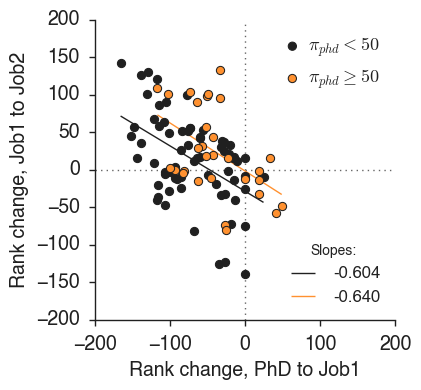

In [13]:
# How many people left?
trans1 = []
trans2 = []
cond = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location in inst and person.followup_title != 'NOT TT':
            phd = inst[person.phd_location]['pi']
            job1 = inst[person.first_asst_job_location]['pi']
            job2 = inst[person.followup_location]['pi']
            
            if job1 == job2:
                continue # skip people who stuck around
            
            trans1.append(phd - job1)
            trans2.append(job1 - job2)

            cond.append(inst[person.phd_location]['pi'] >= 50)
            
fig, ax = plt.subplots(figsize=(5,4))

ylim = 200
xlim = 200
ax.plot([0, 0], [-ylim, ylim], ':', color=DARK_COLOR, zorder=-1)
ax.plot([-xlim, xlim], [0, 0], ':', color=DARK_COLOR, zorder=-1)

trans1 = np.array(trans1)
trans2 = np.array(trans2)
cond = np.array(cond)

regr = linear_model.LinearRegression()

# Plot cond0
keep = np.where(cond == 0)[0]
h1 = ax.scatter(trans1[keep], trans2[keep], color=ALMOST_BLACK, s=35, edgecolor=ALMOST_BLACK, lw=.75)
regr.fit(trans1[keep,np.newaxis], trans2[keep,np.newaxis])
xplot = np.array([np.min(trans1[keep]), np.max(trans1[keep])])
fit0 = ax.plot(xplot, regr.intercept_+(xplot*regr.coef_[0][0]), color=ALMOST_BLACK, zorder=0, label='%.3f' % regr.coef_[0][0])
cond0_slope = regr.coef_[0][0]
cond0_r = sp.stats.spearmanr(trans1[keep], trans2[keep])

# Plot cond1
keep = np.where(cond == 1)[0]
h2 = ax.scatter(trans1[keep], trans2[keep], color=ACCENT_COLOR_1, s=35, edgecolor=ALMOST_BLACK, lw=.75)
regr.fit(trans1[keep,np.newaxis], trans2[keep,np.newaxis])
xplot = np.array([np.min(trans1[keep]), np.max(trans1[keep])])
fit1 = ax.plot(xplot, regr.intercept_+(xplot*regr.coef_[0][0]), color=ACCENT_COLOR_1, zorder=0, label='%.3f' % regr.coef_[0][0])
cond1_slope = regr.coef_[0][0]
cond1_r = sp.stats.spearmanr(trans1[keep], trans2[keep])

ax.set_xlabel('Rank change, PhD to Job1')
ax.set_ylabel('Rank change, Job1 to Job2')

real_legend = plt.legend((h1, h2), (r'$\pi_{phd} < 50$', '$\pi_{phd} \geq 50$'),
           scatterpoints=1, loc='upper right',
           fontsize=LABEL_SIZE-1, frameon=False, handletextpad=-.15)

print 'Correlations:'
print 'cond=0', cond0_r
print 'cond=1', cond1_r

plt.legend(loc='lower right', fontsize=LABEL_SIZE-2, title='Slopes:', frameon=False)

#plt.legend((fit0, fit1), ['a', 'b'], loc='lower left', , 
#           )
ax.add_artist(real_legend)
ax.set_xticks([-200, -100, 0, 100, 200])

finalize(ax)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(figures_dir + 'undo_change.pdf')
plt.show()

Correlations:
Men SpearmanrResult(correlation=-0.34620146314012379, pvalue=0.0028927445488178462)
Women SpearmanrResult(correlation=-0.60041067766615286, pvalue=0.0011831148871243678)


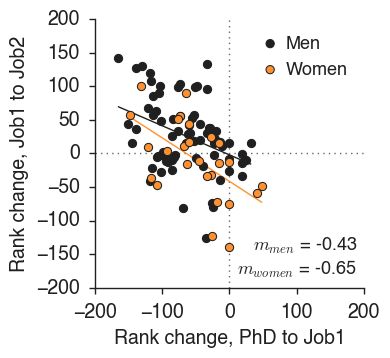

In [10]:
# How many people left?
trans1 = []
trans2 = []
gender = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location in inst and person.followup_title != 'NOT TT':
            phd = inst[person.phd_location]['pi']
            job1 = inst[person.first_asst_job_location]['pi']
            job2 = inst[person.followup_location]['pi']
            
            if job1 == job2:
                continue # skip people who stuck around
            
            #trans1.append(job1 - phd)
            #trans2.append(job2 - job1)
            trans1.append(phd - job1)
            trans2.append(job1 - job2)
            
            gender.append(int(person.is_female))
            
fig, ax = plt.subplots(figsize=(4,4))

ylim = 200
xlim = 200
ax.plot([0, 0], [-ylim, ylim], ':', color=DARK_COLOR, zorder=-1)
ax.plot([-xlim, xlim], [0, 0], ':', color=DARK_COLOR, zorder=-1)

trans1 = np.array(trans1)
trans2 = np.array(trans2)
gender = np.array(gender)

regr = linear_model.LinearRegression()

# Plot men
keep = np.where(gender == 0)[0]
h1 = ax.scatter(trans1[keep], trans2[keep], color=ALMOST_BLACK, s=35, edgecolor=ALMOST_BLACK, lw=.75)
regr.fit(trans1[keep,np.newaxis], trans2[keep,np.newaxis])
xplot = np.array([np.min(trans1[keep]), np.max(trans1[keep])])
ax.plot(xplot, regr.intercept_+(xplot*regr.coef_[0][0]), color=ALMOST_BLACK, zorder=0)
men_slope = regr.coef_[0][0]
men_r = sp.stats.spearmanr(trans1[keep], trans2[keep])

# Plot women
keep = np.where(gender == 1)[0]
h2 = ax.scatter(trans1[keep], trans2[keep], color=ACCENT_COLOR_1, s=35, edgecolor=ALMOST_BLACK, lw=.75)
regr.fit(trans1[keep,np.newaxis], trans2[keep,np.newaxis])
xplot = np.array([np.min(trans1[keep]), np.max(trans1[keep])])
ax.plot(xplot, regr.intercept_+(xplot*regr.coef_[0][0]), color=ACCENT_COLOR_1, zorder=0)
women_slope = regr.coef_[0][0]
women_r = sp.stats.spearmanr(trans1[keep], trans2[keep])

ax.text(190, -180, 
r'''$m_{men}$ = %.2f
$m_{women}$ = %.2f''' % (men_slope, women_slope), fontsize=LABEL_SIZE-1, ha='right')


ax.set_xlabel('Rank change, PhD to Job1')
ax.set_ylabel('Rank change, Job1 to Job2')

plt.legend((h1, h2), ('Men', 'Women'),
           scatterpoints=1, loc='upper right',
           fontsize=LABEL_SIZE-1, frameon=False, handletextpad=-.15)

print 'Correlations:'
print 'Men', men_r
print 'Women', women_r

ax.set_xticks([-200, -100, 0, 100, 200])

finalize(ax)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(figures_dir + 'undo_change.pdf')
plt.show()

So, a slope of -1 here would indicate that the person moves back up by however much they moved down. Keep in mind that this isn't taking into account folks who left academia altogether, but we'll analyze those folks separately. For them, the question will be, are under-performing people the ones who are leaving? Are more people being stolen away to industry? Are there any patterns that might help us predict either case?

## What about the people who left?

Where did they come from? Pretty equal representation from across the board by rank? What about PhD rank? Rank change?

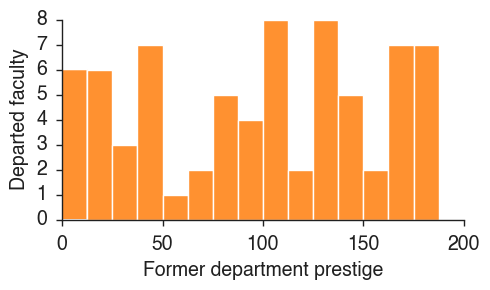

In [11]:
fig, ax = plt.subplots(figsize=(5,3))

x = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location not in inst:
            x.append(inst[person.place]['pi'])

bins = np.linspace(0, 200, 17)
ax.hist(x, bins=bins, color=ACCENT_COLOR_1, edgecolor='w')
ax.set_xlabel('Former department prestige')
ax.set_ylabel('Departed faculty')
            
finalize(ax)
plt.show()

This plot isn't super informative without normalization. There are *far* more faculty in the top-ranked departments. What we really what to know is, is the likelihood that someone will leave greater for the people at the top? In the middle? At the bottom? 

_Normalize based on the number of followups in each bin._

0 1.0
1 1.0
2 0.489398681146
3 0.829005151564
4 1.0
5 0.182790048237
6 0.558539832459
7 0.481454934536
8 0.579713669691
9 1.0
10 0.845654550759
11 1.0
12 0.469019657678
13 0.592941465033
14 0.834037432389
15 0.686322711598
16 0.0248588545626
17 0.529924198265
18 0.453302290709
19 1.0


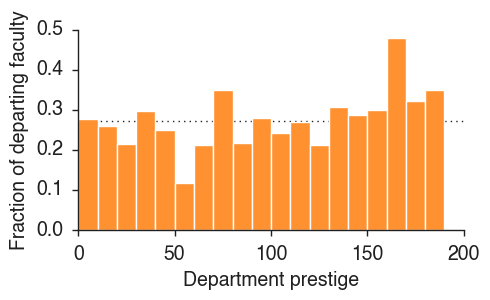

In [12]:
fig, ax = plt.subplots(figsize=(5,3))

x = []
x_norm = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location != person.place:
            x.append(inst[person.place]['pi'])
        x_norm.append(inst[person.place]['pi'])
        
overall = float(len(x)) / len(x_norm)
ax.plot([0,200], [overall, overall], ':', color=ALMOST_BLACK, zorder=0)

bins = np.linspace(0, 200, 21)
vals, bin_edges = np.histogram(x, bins=bins)
bin_widths = bin_edges[1] - bin_edges[0]
norm_vals,_ = np.histogram(x_norm, bins=bins)

ax.bar(bin_edges[:-1], vals/norm_vals, width=bin_widths, color=ACCENT_COLOR_1, edgecolor='w')
ax.set_xlim(0,200)

pvals = []
for i, (v, n) in enumerate(zip(vals, norm_vals)):
    print i, sp.stats.binom_test(v, n, p=overall)
    pvals.append(sp.stats.binom_test(v, n, p=overall))
pvals = np.array(pvals)
mask = np.zeros_like(vals)
flip = np.where(pvals < 0.05)[0]
mask[flip] = 1.

#ax.bar(bin_edges[:-1], mask*vals/norm_vals, width=bin_widths, color=ALMOST_BLACK, edgecolor='w')
            
ax.set_xlabel('Department prestige')
ax.set_ylabel('Fraction of departing faculty')
        
finalize(ax)
plt.show()

0 0.263816963992
1 0.390681680684
2 0.649041269032
3 0.390681680684
4 0.572873578827
5 0.153337099694
6 0.794920272641
7 0.351611840858
8 1.0
9 0.562270309499
10 0.614375197597
11 1.0
12 1.0
13 0.344934309053
14 1.0
15 0.420083592493
16 0.0379588717955
17 1.0
18 0.323942269601
19 1.0


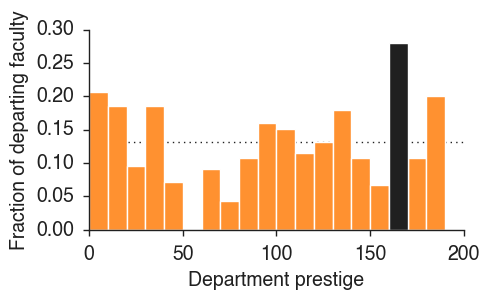

In [13]:
fig, ax = plt.subplots(figsize=(5,3))

x = []
x_norm = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location != person.place and person.followup_location not in inst:
            x.append(inst[person.place]['pi'])
        x_norm.append(inst[person.place]['pi'])
        
overall = float(len(x)) / len(x_norm)
ax.plot([0,200], [overall, overall], ':', color=ALMOST_BLACK, zorder=0)

bins = np.linspace(0, 200, 21)
vals, bin_edges = np.histogram(x, bins=bins)
bin_widths = bin_edges[1] - bin_edges[0]
norm_vals,_ = np.histogram(x_norm, bins=bins)

ax.bar(bin_edges[:-1], vals/norm_vals, width=bin_widths, color=ACCENT_COLOR_1, edgecolor='w')
ax.set_xlim(0,200)

pvals = []
for i, (v, n) in enumerate(zip(vals, norm_vals)):
    print i, sp.stats.binom_test(v, n, p=overall)
    pvals.append(sp.stats.binom_test(v, n, p=overall))
pvals = np.array(pvals)
mask = np.zeros_like(vals)
flip = np.where(pvals < 0.05)[0]
mask[flip] = 1.

ax.bar(bin_edges[:-1], mask*vals/norm_vals, width=bin_widths, color=ALMOST_BLACK, edgecolor='w')
            
ax.set_xlabel('Department prestige')
ax.set_ylabel('Fraction of departing faculty')
        
finalize(ax)
plt.show()

0 0.339441965643
1 0.877144093075
2 0.86531252333
3 0.85080090964
4 0.349349055269
5 0.0970146691276
6 0.41739804637
7 0.122349888904
8 1.0
9 0.483692208808
10 0.742705157914
11 0.64039130599
12 0.23742698433
13 0.201516759713
14 1.0
15 0.596956078712
16 1.0
17 1.0
18 1.0
19 1.0


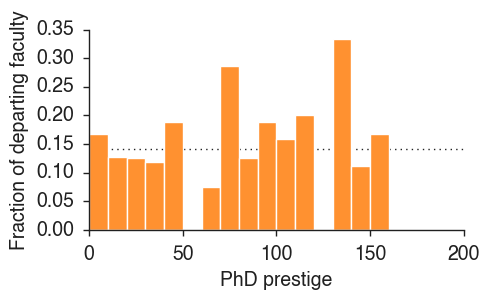

In [14]:
fig, ax = plt.subplots(figsize=(5,3))

x = []
x_norm = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location != person.place and person.followup_location in inst:
            x.append(inst[person.phd_location]['pi'])
        x_norm.append(inst[person.phd_location]['pi'])
        
overall = float(len(x)) / len(x_norm)
ax.plot([0,200], [overall, overall], ':', color=ALMOST_BLACK, zorder=0)

bins = np.linspace(0, 200, 21)
vals, bin_edges = np.histogram(x, bins=bins)
bin_widths = bin_edges[1] - bin_edges[0]
norm_vals,_ = np.histogram(x_norm, bins=bins)

ax.bar(bin_edges[:-1], vals/norm_vals, width=bin_widths, color=ACCENT_COLOR_1, edgecolor='w')
ax.set_xlim(0,200)

pvals = []
for i, (v, n) in enumerate(zip(vals, norm_vals)):
    print i, sp.stats.binom_test(v, n, p=overall)
    pvals.append(sp.stats.binom_test(v, n, p=overall))
pvals = np.array(pvals)
mask = np.zeros_like(vals)
flip = np.where(pvals < 0.05)[0]
mask[flip] = 1.

ax.bar(bin_edges[:-1], mask*vals/norm_vals, width=bin_widths, color=ALMOST_BLACK, edgecolor='w')
            
ax.set_xlabel('PhD prestige')
ax.set_ylabel('Fraction of departing faculty')
        
finalize(ax)
plt.show()

## By rank change!

0 1.0
1 1.0
2 0.204272842217
3 0.285979347938
4 0.314725097795
5 0.510124306377
6 0.87468605316
7 0.75173652041
8 0.769990466711
9 0.00382252165737
10 0.075851322273
11 0.312817474393
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 1.0


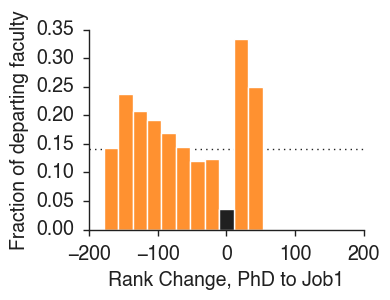

In [15]:
fig, ax = plt.subplots(figsize=(4,3))

x = []
x_norm = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location != person.place and person.followup_location in inst:
            x.append(inst[person.phd_location]['pi'] - inst[person.place]['pi'])
        x_norm.append(inst[person.phd_location]['pi'] - inst[person.place]['pi'])
        
overall = float(len(x)) / len(x_norm)
ax.plot([-200,200], [overall, overall], ':', color=ALMOST_BLACK, zorder=0)

bins = np.linspace(-200, 200, 20)
vals, bin_edges = np.histogram(x, bins=bins)
bin_widths = bin_edges[1] - bin_edges[0]
norm_vals,_ = np.histogram(x_norm, bins=bins)

ax.bar(bin_edges[:-1], vals/norm_vals, width=bin_widths, color=ACCENT_COLOR_1, edgecolor='w')
#ax.set_xlim(0,200)

pvals = []
for i, (v, n) in enumerate(zip(vals, norm_vals)):
    print i, sp.stats.binom_test(v, n, p=overall)
    pvals.append(sp.stats.binom_test(v, n, p=overall))
pvals = np.array(pvals)
mask = np.zeros_like(vals)
flip = np.where(pvals < 0.05)[0]
mask[flip] = 1.

ax.bar(bin_edges[:-1], mask*vals/norm_vals, width=bin_widths, color=ALMOST_BLACK, edgecolor='w')
            
ax.set_xlabel('Rank Change, PhD to Job1')
ax.set_ylabel('Fraction of departing faculty')
        
ax.set_xticks([-200, -100, 0, 100, 200])
    
finalize(ax)
plt.show()

0 1.0
1 1.0
2 0.347140366865
3 0.578204887445
4 1.0
5 0.312819454432
6 0.628021763174
7 1.0
8 0.295662264403
9 0.744434573821
10 0.665415568253
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 1.0


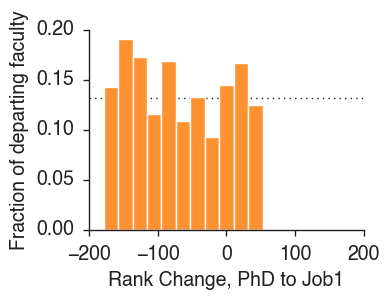

In [16]:
fig, ax = plt.subplots(figsize=(4,3))

x = []
x_norm = []

for person in asst_faculty:
    if 'followup_title' in person:
        if person.followup_location not in inst:
            x.append(inst[person.phd_location]['pi'] - inst[person.place]['pi'])
        x_norm.append(inst[person.phd_location]['pi'] - inst[person.place]['pi'])
        
overall = float(len(x)) / len(x_norm)
ax.plot([-200,200], [overall, overall], ':', color=ALMOST_BLACK, zorder=0)

bins = np.linspace(-200, 200, 20)
vals, bin_edges = np.histogram(x, bins=bins)
bin_widths = bin_edges[1] - bin_edges[0]
norm_vals,_ = np.histogram(x_norm, bins=bins)

ax.bar(bin_edges[:-1], vals/norm_vals, width=bin_widths, color=ACCENT_COLOR_1, edgecolor='w')
#ax.set_xlim(0,200)

pvals = []
for i, (v, n) in enumerate(zip(vals, norm_vals)):
    print i, sp.stats.binom_test(v, n, p=overall)
    pvals.append(sp.stats.binom_test(v, n, p=overall))
pvals = np.array(pvals)
mask = np.zeros_like(vals)
flip = np.where(pvals < 0.05)[0]
mask[flip] = 1.

ax.bar(bin_edges[:-1], mask*vals/norm_vals, width=bin_widths, color=ALMOST_BLACK, edgecolor='w')
            
ax.set_xlabel('Rank Change, PhD to Job1')
ax.set_ylabel('Fraction of departing faculty')
        
ax.set_xticks([-200, -100, 0, 100, 200])
    
finalize(ax)
plt.show()

## Versus Productivity

In [17]:
valid_pub_types = [u'article', u'inproceedings']
years_posthire = 6

for person in asst_faculty:
    last_pub = 0
    if 'followup_title' in person:
        start_year = person.first_asst_job_year
        num_pubs = 0.
        if 'dblp_pubs' in person:
            for pub in person.dblp_pubs:
                if (pub['pub_type'] in valid_pub_types and  # Valid publication type
                    (pub['year'] - start_year <= years_posthire) and # Before cutoff
                    pub['year'] >= start_year):                      # After start
                    num_pubs += 1
                    last_pub = np.max([last_pub, pub['year']])
                    
        if last_pub == 0:
            last_pub = None
            
        person['posthire_pubs'] = num_pubs
        person['posthire_ppy'] = num_pubs / (years_posthire + 1)
        person['last_pub'] = last_pub

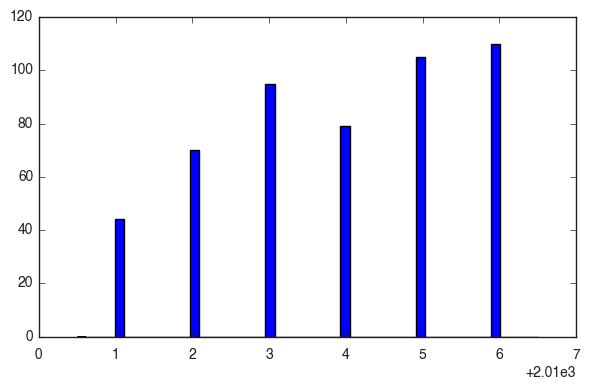

In [18]:
# When were people's last publications? 
last_years = []

for person in asst_faculty:
    if 'last_pub' in person and person['last_pub'] is not None:
        last_years.append(person['last_pub'])
        
bins = np.linspace(2011, 2017) - 0.5
plt.hist(last_years, bins = bins)
plt.show()

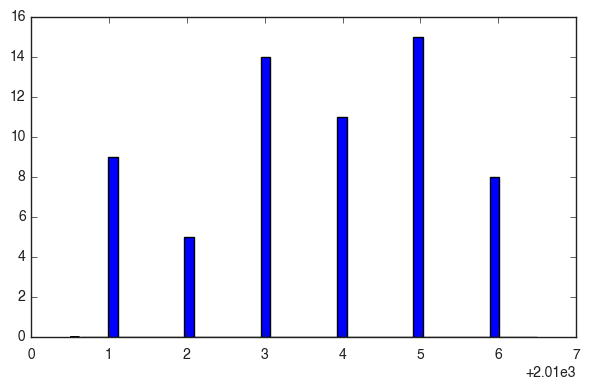

In [19]:
# When were people's last publications? 
last_years = []

for person in asst_faculty:
    if 'last_pub' in person and person['last_pub'] is not None and person['followup_location'] not in inst:
        last_years.append(person['last_pub'])
        
bins = np.linspace(2011, 2017) - 0.5
plt.hist(last_years, bins = bins)
plt.show()

In [20]:
stay = []
gone = []

for person in asst_faculty:
    if 'posthire_ppy' in person:
        if person['followup_location'] == person.place \
           and person['followup_title'] != 'Assistant Professor':
            stay.append(person['posthire_ppy'])
        elif person['followup_location'] not in inst or\
        (person['followup_location'] in inst and inst[person['followup_location']] > ):
            gone.append(person['posthire_ppy'])
            
stay = np.array(stay)
gone = np.array(gone)

fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

bins = np.arange(20)-0.5
w = np.ones_like(stay, dtype=float) / len(stay)
ax.hist(stay, bins=bins, weights=w, alpha=0.7)
w = np.ones_like(gone, dtype=float) / len(gone)
ax.hist(gone, bins=bins, weights=w, alpha=0.7)

ax.set_xlim(-0.5, 20)

finalize(ax)
plt.show()

SyntaxError: invalid syntax (<ipython-input-20-edf1befed69c>, line 8)

In [ ]:
print np.median(stay), np.median(gone)

In [ ]:
fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

colors = [ACCENT_COLOR_1, ALMOST_BLACK]

for person in asst_faculty:
    
    if person.first_asst_job_year > 2010 or person.first_asst_job_year < 2008:
        continue 
    
    if 'posthire_ppy' in person and person['followup_location'] == person.place and person['followup_title'] != "Assistant Professor":
        ax.scatter(inst[person.place]['pi'], person['posthire_ppy'], color=LIGHT_COLOR)
        continue

    if 'posthire_ppy' in person and person['followup_location'] != person.place \
    and person['followup_location'] in inst \
    and inst[person['followup_location']]['pi'] < inst[person.place]['pi']:
        ax.scatter(inst[person.place]['pi'], person['posthire_ppy'], color='g')
        continue

    if 'posthire_ppy' in person and person['followup_location'] != person.place \
    and person['followup_location'] in inst \
    and inst[person['followup_location']]['pi'] > inst[person.place]['pi']:
        ax.scatter(inst[person.place]['pi'], person['posthire_ppy'], color='r')
        continue
        
    if 'posthire_ppy' in person and person['followup_location'] not in inst:
        ax.scatter(inst[person.place]['pi'], person['posthire_ppy'], color='darkred')
        continue
        
ax.set_xlim(0, 200)
ax.set_ylim(0, 15)

finalize(ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

colors = [ACCENT_COLOR_1, ALMOST_BLACK]

for person in asst_faculty:
    
    if person.first_asst_job_year > 2011 or person.first_asst_job_year < 2006:
        continue 
        
    #person.phd_location
    
    if 'posthire_ppy' in person and person['followup_location'] == person.place and person['followup_title'] != "Assistant Professor":
        ax.scatter(inst[person.place]['pi'], person['posthire_ppy'], color=ALMOST_BLACK)
        continue
        
    if 'posthire_ppy' in person and person['followup_location'] not in inst:
        ax.scatter(inst[person.place]['pi'], person['posthire_ppy'], color=ACCENT_COLOR_1)
        continue
    
    """if 'posthire_ppy' in person and person['followup_location'] in inst\
        and inst[person.place]['pi'] < inst[person['followup_location']]['pi']: # moved down
        ax.scatter(inst[person.phd_location]['pi'] - inst[person.place]['pi'], person['posthire_ppy'], color='r')
        continue"""
        
ax.set_xlim(0, 200)
ax.set_ylim(0, 15)

ax.set_xlabel('Departmental Prestige')
ax.set_ylabel('Papers per year, six years out')

finalize(ax)
plt.show()

This must take into account how productive these people are relative to their (potentially already tenured) peers. How does this picture change? First, what does the median productivity look like as a function of institutional prestige?

## Can we predict who will get tenure? (Later: where people go?)

In [694]:
# Profile faculty:
pubs_after = 2005

for person in asst_faculty:
    if 'dblp_pubs' in person:
        start = person.first_asst_job_year        
        last_seen = 2011
        pub_count = 0.
        pub_years = Counter()
        pre_count = 0.
        
        for pub in person['dblp_pubs']:
            if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] >= start:
                pub_count += inflation_adjust(pub['year'])
                pub_years[pub['year']] += 1
                if pub['year'] > last_seen:
                    last_seen = pub['year']
            if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] < start:
                pre_count += inflation_adjust(pub['year'])
                    
        pub_traj = np.array([pub_years[y] for y in xrange(start, last_seen)])
        if len(pub_traj) < 3:
            slope = -100
            intercept = -100
        else:
            [slope,intercept] = np.polyfit(xrange(len(pub_traj)), pub_traj, 1)
        
        person['slope'] = slope
        person['intercept'] = intercept
        person['last_seen'] = last_seen
        person['pub_count'] = pub_count
        person['pre_count'] = pre_count
        
    if 'followup_location' in person:
        if person.followup_location == 'NOT IN ACADEMIA':
            person.status = 'LEFT'
        elif person.followup_location in inst and person.followup_location != person.place:
            person.status = 'RELOCATED'
        elif person.followup_location == person.place:
            person.status = 'STAYED'

In [695]:
inst_authors = {place:[] for place in inst if place not in ignore}
for person in asst_faculty:
    if 'dblp_pubs' in person and person.place in inst_authors:
        inst_authors[person.place].append(person)

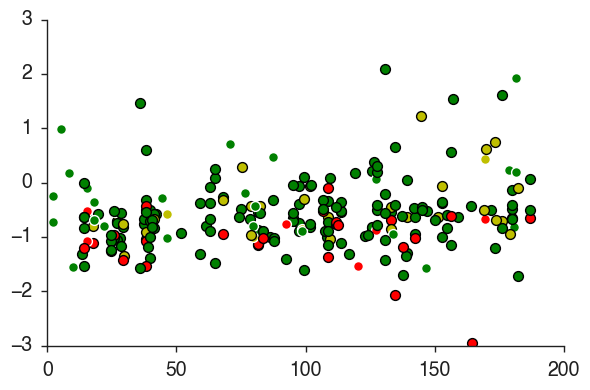

In [696]:
fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

color_dict = {'LEFT': 'r', 'RELOCATED':'y', 'STAYED':'g'}
edgecolor_dict = {0:'k', 1:'w'}

for person in asst_faculty:
    if 'followup_location' in person and person.first_asst_job_year < 2008:
        dept_prod = np.array([p.pub_count/(p.last_seen-pubs_after) for p in inst_authors[person.place]
                              if p.facultyName != person.facultyName])
        z_score = ((person.pub_count/(person.last_seen-pubs_after)) - np.mean(dept_prod))/np.std(dept_prod)
        
        ax.scatter([inst[person.place]['pi']], [z_score], color=color_dict[person.status],
                   edgecolor=edgecolor_dict[inst[person.place]['private']], s=50)
        
ax.set_xlim(0, 200)
ax.set_ylim(-3, 3)
finalize(ax)
plt.show()

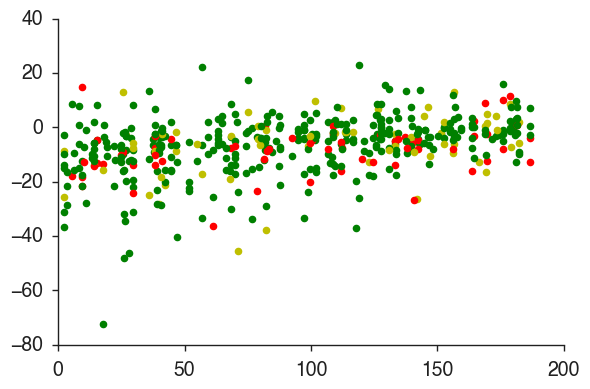

In [697]:
fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

color_dict = {'LEFT': 'r', 'RELOCATED':'y', 'STAYED':'g'}
edgecolor_dict = {0:'k', 1:'w'}

for person in asst_faculty:
    if 'followup_location' in person and person.first_asst_job_year < 2011:
        dept_prod = np.array([p.pub_count/(2012.-person.first_asst_job_year) for p in inst_authors[person.place]
                              if p.facultyName != person.facultyName])
        score = (person.pub_count/(2012.-person.first_asst_job_year)) - np.median(dept_prod)
        
        ax.scatter([inst[person.place]['pi']], [score], color=color_dict[person.status])
        
ax.set_xlim(0, 200)
#ax.set_ylim(-3, 3)
finalize(ax)
plt.show()

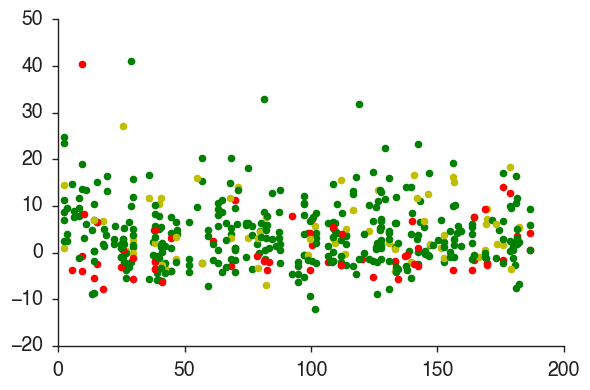

In [698]:
fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

color_dict = {'LEFT': 'r', 'RELOCATED':'y', 'STAYED':'g'}
edgecolor_dict = {0:'k', 1:'w'}

for person in asst_faculty:
    if 'followup_location' in person and person.first_asst_job_year < 2011:
        dept_prod = np.array([p.pub_count/(2012.-p.first_asst_job_year) for p in inst_authors[person.place]
                              if p.facultyName != person.facultyName])
        score = (person.pub_count/(2012.-person.first_asst_job_year)) - np.median(dept_prod)
        
        ax.scatter([inst[person.place]['pi']], [score], color=color_dict[person.status])
        
ax.set_xlim(0, 200)
#ax.set_ylim(-3, 3)
finalize(ax)
plt.show()

In [699]:
# Profile faculty:
pubs_after = 2005
dept_size = {place:0. for place in inst if place not in ignore}

for person in asst_faculty:
    if person.place in dept_size:
        dept_size[person.place] += 1
        
    if 'dblp_pubs' in person:
        start = person.first_asst_job_year        
        last_seen = 2012
        pub_count = 0.
        
        for pub in person['dblp_pubs']:
            if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] >= start \
              and pub['year'] > pubs_after:
                pub_count += inflation_adjust(pub['year'])
                if pub['year'] > last_seen:
                    last_seen = pub['year']
        
        person['last_seen'] = last_seen
        person['pub_count'] = pub_count / float(last_seen - np.max([pubs_after, start]))
        
    if 'followup_location' in person:
        if person.followup_location == 'NOT IN ACADEMIA':
            person.status = 'OUT'
        elif person.followup_location in inst and person.followup_location != person.place:
            if inst[person.place]['pi'] < inst[person.followup_location]['pi']:
                # Where they were was more prestigious than where they are now.
                person.status = 'DOWN'
            else:
                person.status = 'UP'
        elif person.followup_location == person.place:
            person.status = 'STAYED'

In [700]:
knn = 2
nearest_neighbors = {place:[] for place in inst if place not in ignore}

for place in inst:
    if place in ignore: continue 
    pi = inst[place]['pi']
    others = sorted([(np.abs(inst[o]['pi'] - pi), o) for o in inst if o != place and o not in ignore])
    for k in xrange(knn):
        nearest_neighbors[place].append(others[k][1])

In [701]:
for person in asst_faculty:
    if 'followup_location' in person and person.first_asst_job_year < 2012:
        dept_prod = [p.pub_count for p in inst_authors[person.place] if p.facultyName != person.facultyName]
        neighbor_prod = []
        for neighbor in nearest_neighbors[person.place]:
            temp = [p.pub_count for p in inst_authors[neighbor]]
            neighbor_prod += temp
            
        comp_prod = neighbor_prod + dept_prod
        zscore = (person.pub_count-np.mean(comp_prod))/np.std(comp_prod)
        person.zscore = zscore
        person.dept_size = 1 + len(dept_prod)
        person.private = inst[person.place]['private']
        person.prestige = inst[person.place]['pi']
        person.phd_prestige = inst[person.phd_location]['pi']
        person.rank_change = inst[person.place]['pi'] - inst[person.phd_location]['pi']

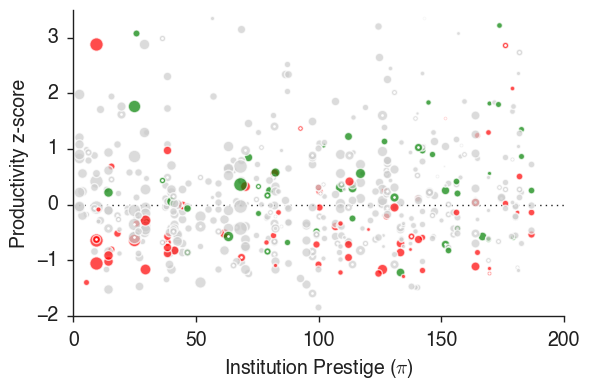

In [751]:
fig, ax = plt.subplots(figsize=SINGLE_FIG_SIZE)

color_dict = {'OUT': 'r', 'DOWN':'.8', 'UP':'g', 'STAYED':'.8'}
edgecolor_dict = {0:'k', 1:'w'}

for person in asst_faculty:
    if 'followup_location' in person and person.first_asst_job_year < 2012:
    
        x = inst[person.place]['pi']
        score = person.zscore
        #score = (person.pub_count/np.median(comp_prod))
        ax.scatter([x], [score], color=color_dict[person.status], 
                   edgecolor='w', s=2*dept_size[person.place], alpha=0.7)
        if person.is_female:
            ax.scatter([x], [score], color='w', s=1, alpha=0.9)
        
ax.set_ylabel('Productivity z-score')
ax.set_xlabel('Institution Prestige ($\pi$)')
        
ax.plot([0,200], [0,0], ':', color=ALMOST_BLACK, zorder=-1000)
ax.set_xlim(0, 200)
ax.set_ylim(-2, 3.5)
finalize(ax)
plt.show()

## Machines that learn

In [761]:
X = []
y = []
#features = ['slope', 'intercept', 'zscore', 'pre_count',
#            'dept_size', 'prestige']
features = ['slope', 'intercept', 'zscore', 'prestige']

for person in asst_faculty:
    if 'followup_location' in person:
        temp_vector = [float(person[f]) for f in features] #+ list(person.topic_dist)
        X.append(temp_vector)
        y.append(float(person.status == 'OUT'))
        
X = np.array(X)
y = np.array(y)

In [762]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=3)

In [763]:
scores = []
for x in xrange(10):
    for train, test in StratifiedKFold(y, 20, random_state=x):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        preds = probas_[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], preds)
        roc_auc = auc(fpr, tpr)
        scores.append(roc_auc)
        #print classifier.feature_importances_

In [764]:
np.mean(scores)

0.6499145833333333

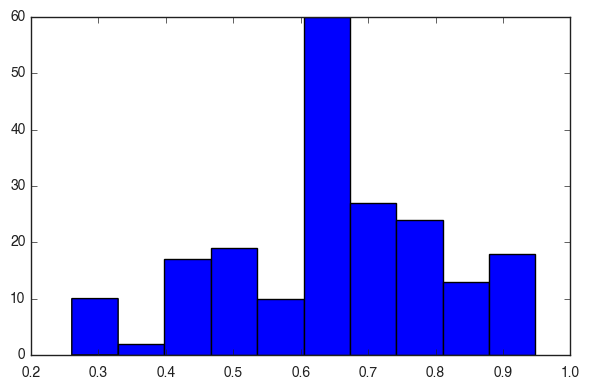

In [765]:
plt.hist(scores)
plt.show()